In [ ]:
from transformers import (
    AutoTokenizer, # language models
    AutoModelForCausalLM,
    Trainer, # fine-tuning
    TrainingArguments,
    DataCollatorForLanguageModeling, # part of pipeline responsible for assembling
    BitsAndBytesConfig, # BitsAndBytes for quantum compression, less data size for models, yet not losing in speed at all
    pipeline
    )

import torch # pyTorch
import safetensors.torch

from datasets import Dataset # converting text file in dataset (increases file reading speed)
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model # (Parameter Efficient Fine Tuning) -> we take LoRA only
# import torch.optim.adam # Adaptive Moment Estimation (Adam)

# !pip install -U bitsandbytes
#!pip install --upgrade transformers

In [ ]:
def import_model(model_name):
  model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16, ## gpu support
    device_map="auto",
    quantization_config=BitsAndBytesConfig(load_in_8bit=True) # bitsAndBytes
    )
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  tokenizer.pad_token = tokenizer.eos_token # in case some custom models dont have pad_token by default
  return model, tokenizer

models = ["deepseek-ai/deepseek-llm-7b-base", "mistralai/Mistral-7B-Instruct-v0.3", "meta-llama/Llama-3.1-8B-Instruct"]
deepseek_model, deepseek_tokenizer = import_model(models[0])
# mistral_model, mistral_tokenizer = import_model(models[1])
#llama_model, llama_tokenizer = import_model(models[2])

In [ ]:
def file_read(file_name):
  with open(file_name, 'r') as file:
    file = file.read()
    # dataset = [sentences[i:i+40] for i in range(0, len(sentences), 40)] # aint work, there's going to be an error, to large dataset, need to use Dataset
  dataset = Dataset.from_dict({"text": file.split("\n\n")})
  return dataset

dataset = file_read("church_text")

def make_token_func(tokenizer, max_length=512): # a constructor for different tokenizers
    def token_func(example):
        return tokenizer(
            example["text"],
            truncation=True,
            padding="max_length",
            max_length=max_length,
        )
    return token_func

token_func = make_token_func(deepseek_tokenizer)
token_dataset = dataset.map(token_func, batched=True)


In [ ]:
def lora_training(model):
  model = prepare_model_for_kbit_training(model)
  lora_config = LoraConfig(
    r=8, # a rank, the bigger the rank, more accuracy we get, but becomes slower
    lora_alpha=42, # an influence of LoRA on a model
    target_modules=["q_proj", "v_proj"], # there are modules we touch to change, q_proj = query, v_proj = value
    lora_dropout=0.05, # in order to avoid overtraining
    bias="none", # means do not touch bias
    task_type="CAUSAL_LM" # model wise
  )
  model = get_peft_model(model, lora_config)
  model.gradient_checkpointing_enable()
  return model

deepseek_model = lora_training(deepseek_model)


In [ ]:
def model_train(model, tokenizer, dataset):
  data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
  )

  # adam is working under the hood by default
  training_args = TrainingArguments(
      output_dir=f"./deepseek-clear-continued-pretrain-max_steps{1000}",
      overwrite_output_dir=True,
      max_steps=1000,
      per_device_train_batch_size=10, # количество рассмотренных обьектов за один раз -> усреднение -> лучшая точность
      save_steps=50,
      save_total_limit=1,
      prediction_loss_only=True,
      fp16=True,
      learning_rate=5e-6,
      logging_steps=20,
  )
  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=dataset,
      tokenizer=tokenizer,
      data_collator=data_collator,
  )
  trainer.train()

model_train(deepseek_model, deepseek_tokenizer, token_dataset)

In [ ]:
def lora_adapters_attach(model, checkpoint):
  adapters_weights = safetensors.torch.load_file(f"./llama-continued-pretrain-max_steps{1000}/checkpoint-{checkpoint}/adapter_model.safetensors")
  model.load_state_dict(adapters_weights, strict=False)
  return model

deepseek = lora_adapters_attach(deepseek_model, 1000)


In [ ]:
def gen(question, model, tokenizer):
    prompt = f"Question: {question}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_length=500,
        num_return_sequences=1,
        do_sample=False, ## variety, turn off for now
        top_p=0.95,
        temperature=0.7, ## temp
        pad_token_id=tokenizer.eos_token_id,
    )
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = answer.split("Answer:")[-1].strip()
    return answer

gen("The church of Panagia Aggeloktisti", deepseek_model, deepseek_tokenizer)

In [ ]:
import shutil
from google.colab import files
def save_trained_model(model, checkpoint):
  file = shutil.make_archive(f"{model.__class__.__name__}-checkpoint", 'zip', f"./deepseek-clear-continued-pretrain-max_steps{1000}/checkpoint-{checkpoint}/")
  files.download(file)

save_trained_model(deepseek_model, 1000)

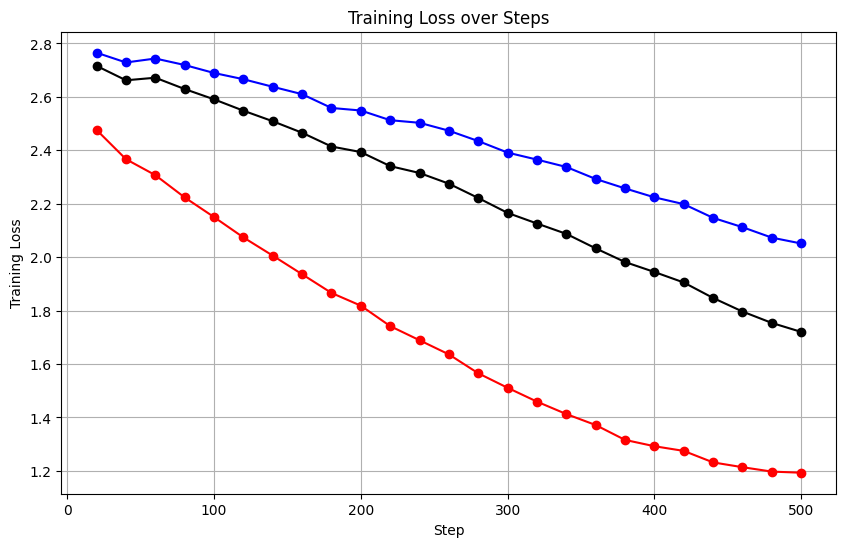

In [19]:
### Training loss visualisation
import matplotlib.pyplot as plt

# 500 steps cap
steps = [
    20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300,
    320, 340, 360, 380, 400, 420, 440, 460, 480, 500
]

deepseek_training_loss = [
    2.765200, 2.728700, 2.743500, 2.719200, 2.689300, 2.666000, 2.637700, 2.610000,
    2.558400, 2.548900, 2.512600, 2.502900, 2.473300, 2.434500, 2.391300, 2.365100,
    2.337500, 2.292600, 2.257300, 2.223900, 2.198400, 2.147000, 2.112200, 2.073000,
    2.051100
]

mistral_training_loss = [
    2.476000, 2.366600, 2.306900, 2.223500, 2.149900,
    2.073800, 2.005600, 1.935900, 1.866000, 1.818300,
    1.741800, 1.688900, 1.635900, 1.565200, 1.510900,
    1.459100, 1.412600, 1.371500, 1.315800, 1.292200,
    1.274700, 1.231600, 1.213700, 1.197200, 1.193000
]

llama_training_loss = [
    2.7158, 2.6620, 2.6716, 2.6292, 2.5907,
    2.5482, 2.5087, 2.4656, 2.4141, 2.3933,
    2.3407, 2.3150, 2.2749, 2.2214, 2.1656,
    2.1259, 2.0871, 2.0329, 1.9817, 1.9444,
    1.9051, 1.8472, 1.7964, 1.7537, 1.7201
]

plt.figure(figsize=(10,6))
plt.plot(steps, deepseek_training_loss, marker='o', linestyle='-', color='blue')
plt.plot(steps, mistral_training_loss, marker='o', linestyle='-', color='red')
plt.plot(steps, llama_training_loss, marker='o', linestyle='-', color='black')
plt.title('Training Loss over Steps')
plt.xlabel('Step')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()
